### Import Statements

In [322]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import pickle
import scipy.stats

%matplotlib inline

In [323]:
from Bio import SeqIO


### Set matplotlib text export settings for Adobe Illustrator

In [324]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#### Pandas Viewing Settings

In [325]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [326]:
#from panqc.utils import parse_PresAbs_Rtab, parse_PresAbs_CSV_Roary, parse_PresAbs_CSV_Panaroo, get_PG_Stats_FromPresAbs
from panqc.utils import get_PG_Stats_FromPresAbs


In [327]:
def parse_PresAbs_Rtab_V2(PresAbs_Rtab_PATH):
    '''
    This function parsesthe `gene_presence_absence.csv` file output by Panaroo '''

    i_Gene_PresAbs_DF = pd.read_csv(PresAbs_Rtab_PATH, sep = "\t")

    ### Relabel Columns for presence/absence tracking
    i_Gene_PresAbs_DF.columns = [ x.split(".CDHIT")[0] for x in i_Gene_PresAbs_DF.columns ]


    ListOf_SampleID_Cols = list(i_Gene_PresAbs_DF.drop(["Gene"], axis=1).columns)
    
    i_Gene_PresAbs_DF["NumAsm_WiGene"] = i_Gene_PresAbs_DF[ListOf_SampleID_Cols].sum(axis = 1)

    i_Gene_PresAbs_DF = i_Gene_PresAbs_DF.sort_values(by='NumAsm_WiGene', ascending=False)
    i_Gene_PresAbs_DF = i_Gene_PresAbs_DF.set_index("Gene", drop=False)

    return i_Gene_PresAbs_DF

In [328]:
def infer_PG_Stats_FromRtab(i_Pangene_Rtab, i_NumSamples, verbose = False):

    Pangene_Rtab_DF = parse_PresAbs_Rtab_V2(i_Pangene_Rtab)

    NumTotalGenes, NumCoreGenes, NumAccessoryGenes = get_PG_Stats_FromPresAbs(Pangene_Rtab_DF, i_NumSamples)

    listOf_PG_Rows = []
    listOf_PG_Rows.append( ("Total genes", "(0% <= strains <= 100%)", NumTotalGenes) )
    listOf_PG_Rows.append( ("Accessory genes", "(0% <= strains < 99%)", NumAccessoryGenes) )
    listOf_PG_Rows.append( ("Core genes", "(99% <= strains <= 100%)", NumCoreGenes) )

    Pangene_PG_Stats_DF = pd.DataFrame(listOf_PG_Rows)
    Pangene_PG_Stats_DF.columns = ["Category", "Range", "GeneCount"]
    
    return Pangene_PG_Stats_DF

In [329]:

def read_PanarooSummaryStats(input_Panaroo_SummaryStats_TXT):
    
    i_Panaroo_Stats_DF = pd.read_csv(input_Panaroo_SummaryStats_TXT, sep = "\t", header=None)
    i_Panaroo_Stats_DF.columns = ["Category", "Range", "GeneCount"]

    Acc_GenesCount = i_Panaroo_Stats_DF["GeneCount"].values[-1] - i_Panaroo_Stats_DF["GeneCount"].values[0]

    i_Panaroo_AccGenesRow = ["Accessory genes","(0% <= strains < 99%)", Acc_GenesCount]

    i_Panaroo_Stats_DF.loc[len(i_Panaroo_Stats_DF.index)] = i_Panaroo_AccGenesRow

    #listOfCat_ToKeep = ["Core genes", "Accessory Genes", "Total genes"]

    i_Panaroo_Stats_DF = i_Panaroo_Stats_DF[ i_Panaroo_Stats_DF["Category"].isin(listOfCat_ToKeep)]   

    # https://www.statology.org/pandas-add-row-to-dataframe/#:~:text=You%20can%20use%20the%20df,loc%5Blen(df. 

    return i_Panaroo_Stats_DF

In [330]:
def read_Ppanggolin_ContextStats(i_Ppanggolin_Content_TXT, verbose = False):
    if verbose:
        print(f"reading Ppangolin stats from {i_Ppanggolin_Content_TXT}")
        
    with open(i_Ppanggolin_Content_TXT, "r") as f:

        #NumCoreGenes = -1
        #NumShellGenes = -1
        #NumCloudGenes = -1
        for line in f:
            #print(line)
            line_split = line.split(": ")

            Key = line_split[0].split(" ")[0]
            Value = line_split[-1].strip()

            if Key == "Persistent": NumCoreGenes = int(Value)
            elif Key == "Shell": NumShellGenes = int(Value)
            elif Key == "Cloud": NumCloudGenes = int(Value)
        print(NumShellGenes, NumCloudGenes)
        NumAccessoryGenes = NumShellGenes + NumCloudGenes
        NumTotalGenes = NumCoreGenes + NumAccessoryGenes

        #print(NumCoreGenes, NumAccessoryGenes, NumTotalGenes)

    listOf_PG_Rows = []
    listOf_PG_Rows.append( ("Total genes", "(0% <= strains <= 100%)", NumTotalGenes) )
    listOf_PG_Rows.append( ("Accessory genes", "(0% <= strains < 99%)", NumAccessoryGenes) )
    listOf_PG_Rows.append( ("Core genes", "(99% <= strains <= 100%)", NumCoreGenes) )

    PPanggolin_Summary_DF = pd.DataFrame(listOf_PG_Rows)
    PPanggolin_Summary_DF.columns = ["Category", "Range", "GeneCount"]
    
    return PPanggolin_Summary_DF

# Parse sample metadata & preprocessed genome info/results

## Parse sample Metadata (N = 151)

In [331]:
Repo_DataDir = "../../Data"
InputAsmPath_Dir = f"{Repo_DataDir}/231121.InputAsmTSVs.MtbSetV3.151CI"

MtbSetV3_151CI_InputAsmPATHs_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAndSRAsm.FAPATHs.V1.tsv"

MtbSetV3_151CI_AsmSumm_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAsm.AsmSummary.V2.tsv"

WGA151CI_AsmSummary_DF = pd.read_csv(MtbSetV3_151CI_AsmSumm_TSV, sep = "\t")

SampleIDs_151CI_SOI = list( WGA151CI_AsmSummary_DF["SampleID"].values )
WGA151CI_SampleIDs = SampleIDs_151CI_SOI

ID_To_PrimLineage_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'PrimaryLineage']].values)
ID_To_SubLineage_Dict = dict( WGA151CI_AsmSummary_DF[["SampleID", "Lineage"]].values)
ID_To_Dataset_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'Dataset_Tag']].values)
WGA151CI_AsmSummary_DF.shape

(151, 7)

# Define output dir of the Mtb-WGA-SMK processing pipeline

In [332]:
# Define pipeline output directories

WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

#MtbWGA_SMK_Pipeline_OutputDir = WGA_SMK_Outputs_Dir + "/220427_WGA158CI_V1"
WGA151CI_SMK_OutputDir = WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"
Mtb_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir

In [333]:
target_OutputDir = Mtb_SMK_Pipeline_OutputDir


i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"

i_Pangene_OutDir = f"{i_Pangenome_Dir}/pangene"


In [334]:
!ls -1 $i_Pangenome_Dir/pangene

Mtb151CI.Bakta.AllCDSMerged.faa
Mtb151CI.CDHIT0.95.Clustered.faa
Mtb151CI.CDHIT0.95.Clustered.faa.clstr
Mtb151CI.CDHIT0.95.Miniprot0.95.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.95.Miniprot0.95.pangene.gfa
Mtb151CI.CDHIT0.95.Miniprot0.98.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.95.Miniprot0.98.pangene.gfa
Mtb151CI.CDHIT0.95.Miniprot0.99.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.95.Miniprot0.99.pangene.gfa
Mtb151CI.CDHIT0.95.Miniprot0.9.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.95.Miniprot0.9.pangene.gfa
Mtb151CI.CDHIT0.98.Clustered.faa
Mtb151CI.CDHIT0.98.Clustered.faa.clstr
Mtb151CI.CDHIT0.98.Miniprot0.95.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.98.Miniprot0.95.pangene.gfa
Mtb151CI.CDHIT0.98.Miniprot0.98.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.98.Miniprot0.98.pangene.gfa
Mtb151CI.CDHIT0.98.Miniprot0.99.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.98.Miniprot0.99.pangene.gfa
Mtb151CI.CDHIT0.98.Miniprot0.9.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.98.Miniprot0.9.pangene.gfa
Mtb1

In [335]:
!ls -1 $i_Pangene_OutDir | grep Rtab

Mtb151CI.CDHIT0.95.Miniprot0.95.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.95.Miniprot0.98.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.95.Miniprot0.99.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.95.Miniprot0.9.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.98.Miniprot0.95.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.98.Miniprot0.98.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.98.Miniprot0.99.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.98.Miniprot0.9.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.9.Miniprot0.95.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.9.Miniprot0.98.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.9.Miniprot0.99.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.9.Miniprot0.9.gene_presence_absence.Rtab


In [336]:
Mtb_LR_Pangene_C90M90_Rtab = f"{i_Pangene_OutDir}/Mtb151CI.CDHIT0.95.Miniprot0.99.gene_presence_absence.Rtab"    
!ls -lah $i_Gene_PresAbs_Rtab_PATH

-rw-rw-r-- 1 mm774 farhat 1.3M Nov 20 13:38 /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/pangene/Mtb151CI.CDHIT0.98.Miniprot0.99.gene_presence_absence.Rtab


In [337]:
Pangene_C90M90_PA = parse_PresAbs_Rtab_V2(Mtb_LR_Pangene_C90M90_Rtab)
Pangene_C90M90_PA.shape

(4215, 153)

In [338]:
N_Total, N_Core, N_Acc = get_PG_Stats_FromPresAbs(Pangene_C90M90_PA, 151)

Accessory Thresh: 149.49


In [339]:
#!ls -1 $i_Pangenome_Dir

In [340]:
!ls -1 $i_Pangene_OutDir | grep Rtab

Mtb151CI.CDHIT0.95.Miniprot0.95.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.95.Miniprot0.98.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.95.Miniprot0.99.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.95.Miniprot0.9.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.98.Miniprot0.95.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.98.Miniprot0.98.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.98.Miniprot0.99.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.98.Miniprot0.9.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.9.Miniprot0.95.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.9.Miniprot0.98.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.9.Miniprot0.99.gene_presence_absence.Rtab
Mtb151CI.CDHIT0.9.Miniprot0.9.gene_presence_absence.Rtab


## Define output dirs of pipeline

In [341]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                         'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80',
                         'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default',
                         'Ppanggolin_I0.80C0.80',
                         'Ppanggolin_I0.80C0.90',
                         'Ppanggolin_I0.90C0.80',
                         'Ppanggolin_I0.90C0.90',
                         'Pangene_CDHIT0.95.Miniprot0.95',
                         'Pangene_CDHIT0.95.Miniprot0.98',
                         'Pangene_CDHIT0.95.Miniprot0.99',
                         'Pangene_CDHIT0.98.Miniprot0.95',
                         'Pangene_CDHIT0.98.Miniprot0.98',
                         'Pangene_CDHIT0.98.Miniprot0.99',] 


target_OutputDir = Mtb_SMK_Pipeline_OutputDir

i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"

listOfCat_ToKeep = ["Core genes", "Accessory genes", "Total genes"]


dictOf_PG_OutInfo = {}
dictOf_PG_PresAbs_DF = {}
dictOf_PG_OutDir_PATHs = {}

for i_SampleSet in ["All"]:
    
    dictOf_PG_OutInfo[i_SampleSet] = {}
    dictOf_PG_OutDir_PATHs[i_SampleSet] = {}
    dictOf_PG_PresAbs_DF[i_SampleSet] = {}
    
    for AnnoPipeline in ["Bakta", ]:
        
        dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline] = {}
        dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline] = {}
        dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline] = {}
        
        for AsmTech in ["LongRead",]:       
            
            dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech] = {}
            dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech] = {}
            dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline][AsmTech] = {}
            
            
            for i_PipeNameWiParam in tqdm(PipeName_WiParam_List):
                
                dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = {}
                                
                if i_SampleSet == "All": DataSetSuffix = "_AllIsolates"  

                if AsmTech == "LongRead": SeqTechPrefix = ""
                elif AsmTech == "ShortRead": SeqTechPrefix = "SR_"

                if AnnoPipeline == "Bakta": AnnoSuffix = ""
                elif AnnoPipeline == "PGAP": AnnoSuffix = "_WiPGAPAnno_V1"


                i_Pipeline_OutDir = f"{i_Pangenome_Dir}/{SeqTechPrefix}{i_PipeNameWiParam}{DataSetSuffix}{AnnoSuffix}"

                i_Pangene_OutDir  = f"{i_Pangenome_Dir}/pangene"
                
                if "Pangene" in i_PipeNameWiParam:
                    
                    Pangene_ParamString = i_PipeNameWiParam[8:]
                    print(Pangene_ParamString)
                    i_Gene_PresAbs_Rtab_PATH = f"{i_Pangene_OutDir}/Mtb151CI.{Pangene_ParamString}.gene_presence_absence.Rtab"    

                    i_PG_Stats_DF = infer_PG_Stats_FromRtab(i_Gene_PresAbs_Rtab_PATH, 151)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)

                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_Rtab"] = i_Gene_PresAbs_Rtab_PATH
                
                
                if "Panaroo" in i_PipeNameWiParam:
                    
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/summary_statistics.txt"

                    i_PG_Stats_DF = read_PanarooSummaryStats(i_PG_Summary_Txt)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)

                    i_Gene_PresAbs_CSV_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.csv"    
                    i_Pangenome_Ref_FA_PATH = f"{i_Pipeline_OutDir}/pan_genome_reference.fa"
                    
                    #i_Gene_PresAbs_DF = parse_Panaroo_GenePresAbs_CSV(i_Gene_PresAbs_CSV_PATH)  

                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_CSV"] = i_Gene_PresAbs_CSV_PATH
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Pangenome_Ref_FA"] = i_Pangenome_Ref_FA_PATH


                elif "Roary" in i_PipeNameWiParam:
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/summary_statistics.txt"

                    i_PG_Stats_DF = read_PanarooSummaryStats(i_PG_Summary_Txt)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)

                    i_Gene_PresAbs_CSV_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.csv"    

                    i_Pangenome_Ref_FA_PATH = f"{i_Pipeline_OutDir}/pan_genome_reference.fa"
                    
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_CSV"] = i_Gene_PresAbs_CSV_PATH
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Pangenome_Ref_FA"] = i_Pangenome_Ref_FA_PATH

                    
                elif "Ppanggolin" in i_PipeNameWiParam:

                    
                    i_Gene_PresAbs_Rtab_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.Rtab"    

                    i_PG_Stats_DF = infer_PG_Stats_FromRtab(i_Gene_PresAbs_Rtab_PATH, 151)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                                        
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)
                    
                    i_Gene_PresAbs_Rtab_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.Rtab"    
                    
                                          
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_Rtab"] = i_Gene_PresAbs_Rtab_PATH


                dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = i_PG_Stats_DF
                
                #dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = i_Gene_PresAbs_DF
                
                dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Stats_TXT"] = i_PG_Summary_Txt


 60%|██████    | 12/20 [00:00<00:00, 39.09it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49
Accessory Thresh: 149.49


 75%|███████▌  | 15/20 [00:00<00:00, 23.72it/s]

Accessory Thresh: 149.49
CDHIT0.95.Miniprot0.95
Accessory Thresh: 149.49
CDHIT0.95.Miniprot0.98
Accessory Thresh: 149.49
CDHIT0.95.Miniprot0.99


 90%|█████████ | 18/20 [00:00<00:00, 19.46it/s]

Accessory Thresh: 149.49
CDHIT0.98.Miniprot0.95
Accessory Thresh: 149.49
CDHIT0.98.Miniprot0.98
Accessory Thresh: 149.49
CDHIT0.98.Miniprot0.99


100%|██████████| 20/20 [00:00<00:00, 17.06it/s]

Accessory Thresh: 149.49


In [342]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"].keys()

dict_keys(['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs', 'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict', 'Panaroo_Moderate', 'Panaroo_Sensitive', 'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90', 'Roary_NoSplitParalogs', 'Roary_Default', 'Ppanggolin_I0.80C0.80', 'Ppanggolin_I0.80C0.90', 'Ppanggolin_I0.90C0.80', 'Ppanggolin_I0.90C0.90', 'Pangene_CDHIT0.95.Miniprot0.95', 'Pangene_CDHIT0.95.Miniprot0.98', 'Pangene_CDHIT0.95.Miniprot0.99', 'Pangene_CDHIT0.98.Miniprot0.95', 'Pangene_CDHIT0.98.Miniprot0.98', 'Pangene_CDHIT0.98.Miniprot0.99'])

In [343]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Ppanggolin_I0.80C0.80"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
0,Total genes,(0% <= strains <= 100%),4772,Bakta,Ppanggolin_I0.80C0.80,LongRead,All
2,Core genes,(99% <= strains <= 100%),3650,Bakta,Ppanggolin_I0.80C0.80,LongRead,All
1,Accessory genes,(0% <= strains < 99%),1122,Bakta,Ppanggolin_I0.80C0.80,LongRead,All


In [344]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Pangene_CDHIT0.95.Miniprot0.95"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
0,Total genes,(0% <= strains <= 100%),4192,Bakta,Pangene_CDHIT0.95.Miniprot0.95,LongRead,All
2,Core genes,(99% <= strains <= 100%),3795,Bakta,Pangene_CDHIT0.95.Miniprot0.95,LongRead,All
1,Accessory genes,(0% <= strains < 99%),397,Bakta,Pangene_CDHIT0.95.Miniprot0.95,LongRead,All


In [345]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Pangene_CDHIT0.98.Miniprot0.99"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
0,Total genes,(0% <= strains <= 100%),4245,Bakta,Pangene_CDHIT0.98.Miniprot0.99,LongRead,All
2,Core genes,(99% <= strains <= 100%),3792,Bakta,Pangene_CDHIT0.98.Miniprot0.99,LongRead,All
1,Accessory genes,(0% <= strains < 99%),453,Bakta,Pangene_CDHIT0.98.Miniprot0.99,LongRead,All


In [346]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Panaroo_Strict_MergeParalogs"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
4,Total genes,(0% <= strains <= 100%),4200,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All
0,Core genes,(99% <= strains <= 100%),3779,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All
5,Accessory genes,(0% <= strains < 99%),421,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All


# 1) Merge all Pan-genome counts accross all combinations evaluated

In [347]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                         'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80',
                         'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default',
                         'Ppanggolin_I0.80C0.80',
                         'Ppanggolin_I0.80C0.90',
                         'Ppanggolin_I0.90C0.80',
                         'Ppanggolin_I0.90C0.90',
                         'Pangene_CDHIT0.95.Miniprot0.95',
                         'Pangene_CDHIT0.95.Miniprot0.98',
                         'Pangene_CDHIT0.95.Miniprot0.99',
                         'Pangene_CDHIT0.98.Miniprot0.95',
                         'Pangene_CDHIT0.98.Miniprot0.98',
                         'Pangene_CDHIT0.98.Miniprot0.99',] 


listOf_PG_InfoDFs = []
for i_SampleSet in ["All"]:
    for AnnoPipeline in ["Bakta",]:
        for AsmTech in ["LongRead",]:
            for i_PipeNameWiParam in PipeName_WiParam_List:
                i_PG_Stats_DF = dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]
                
                listOf_PG_InfoDFs.append(i_PG_Stats_DF)


PG_Merged_Stats_LRandSR_DF = pd.concat(listOf_PG_InfoDFs)

PG_Merged_Stats_LRandSR_DF["MethodAndTech"] = PG_Merged_Stats_LRandSR_DF["Method"] + "_" +PG_Merged_Stats_LRandSR_DF["SeqType"]

PG_Merged_Stats_LRandSR_DF["MethodAndTechAndAnno"] = PG_Merged_Stats_LRandSR_DF["Method"] + "_" +PG_Merged_Stats_LRandSR_DF["SeqType"]  + "_" +PG_Merged_Stats_LRandSR_DF["Annotation"]  

PG_Merged_Stats_LRandSR_DF["AnnoAndTech"] = PG_Merged_Stats_LRandSR_DF["Annotation"] + "-" + PG_Merged_Stats_LRandSR_DF["SeqType"]

PG_Merged_Stats_LRandSR_DF["PangenomeTool"] = PG_Merged_Stats_LRandSR_DF["Method"].str.split("_").str[0]


PG_Merged_Stats_LRandSR_DF.shape


(60, 11)

In [348]:
PG_Merged_Stats_LRandSR_DF["PangenomeTool"].value_counts()

Panaroo       18
Pangene       18
Roary         12
Ppanggolin    12
Name: PangenomeTool, dtype: int64

In [349]:
PG_Merged_Stats_LRandSR_DF.head()

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
4,Total genes,(0% <= strains <= 100%),4200,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
0,Core genes,(99% <= strains <= 100%),3779,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),421,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
4,Total genes,(0% <= strains <= 100%),4280,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
0,Core genes,(99% <= strains <= 100%),3825,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo


In [350]:
PG_Merged_Stats_LRandSR_DF["PangenomeTool"].value_counts()

Panaroo       18
Pangene       18
Roary         12
Ppanggolin    12
Name: PangenomeTool, dtype: int64

In [351]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                         'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80',
                         'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default',
                         'Ppanggolin_I0.80C0.80',
                         'Ppanggolin_I0.80C0.90',
                         'Ppanggolin_I0.90C0.80',
                         'Ppanggolin_I0.90C0.90',
                         'Pangene_CDHIT0.95.Miniprot0.95',
                         'Pangene_CDHIT0.95.Miniprot0.98',
                         'Pangene_CDHIT0.95.Miniprot0.99',
                         'Pangene_CDHIT0.98.Miniprot0.95',
                         'Pangene_CDHIT0.98.Miniprot0.98',
                         'Pangene_CDHIT0.98.Miniprot0.99',] 


PGCombos_TickLabels = ['Panaroo \n (Strict & MergeParalogs)', 'Panaroo \n (Moderate & MergeParalogs)',
                       'Panaroo \n (Sensitive & MergeParalogs)', 'Panaroo \n (Strict)',
                       'Panaroo \n (Moderate)', 'Panaroo \n (Sensitive)', 
                       'Roary \n (MergeParalogs & I80)', 'Roary \n (MergeParalogs & I90)',
                       'Roary \n (MergeParalogs)',  'Roary \n (Default)',
                       'Ppanggolin (I0.80-C0.80)',
                       'Ppanggolin (I0.80-C0.90)',
                       'Ppanggolin (I0.90-C0.80)',
                       'Ppanggolin (I0.90-C0.90)',
                       'Pangene \n (C0.95-M0.95)',
                       'Pangene \n (C0.95-M0.98)',
                       'Pangene \n (C0.95-M0.99)',
                       'Pangene \n (C0.98-M0.95)',
                       'Pangene \n (C0.98-M0.98)',
                       'Pangene \n (C0.98-M0.99)',
                       ]


PGCombos_dictOfValues_To_Label = {}  

for i in range(len(PipeName_WiParam_List)):
        
    PGCombos_dictOfValues_To_Label[PipeName_WiParam_List[i]]   =   PGCombos_TickLabels[i]
    
PGCombos_dictOfValues_To_Label

{'Panaroo_Strict_MergeParalogs': 'Panaroo \n (Strict & MergeParalogs)',
 'Panaroo_Moderate_MergeParalogs': 'Panaroo \n (Moderate & MergeParalogs)',
 'Panaroo_Sensitive_MergeParalogs': 'Panaroo \n (Sensitive & MergeParalogs)',
 'Panaroo_Strict': 'Panaroo \n (Strict)',
 'Panaroo_Moderate': 'Panaroo \n (Moderate)',
 'Panaroo_Sensitive': 'Panaroo \n (Sensitive)',
 'Roary_NoSplitParalogs_I80': 'Roary \n (MergeParalogs & I80)',
 'Roary_NoSplitParalogs_I90': 'Roary \n (MergeParalogs & I90)',
 'Roary_NoSplitParalogs': 'Roary \n (MergeParalogs)',
 'Roary_Default': 'Roary \n (Default)',
 'Ppanggolin_I0.80C0.80': 'Ppanggolin (I0.80-C0.80)',
 'Ppanggolin_I0.80C0.90': 'Ppanggolin (I0.80-C0.90)',
 'Ppanggolin_I0.90C0.80': 'Ppanggolin (I0.90-C0.80)',
 'Ppanggolin_I0.90C0.90': 'Ppanggolin (I0.90-C0.90)',
 'Pangene_CDHIT0.95.Miniprot0.95': 'Pangene \n (C0.95-M0.95)',
 'Pangene_CDHIT0.95.Miniprot0.98': 'Pangene \n (C0.95-M0.98)',
 'Pangene_CDHIT0.95.Miniprot0.99': 'Pangene \n (C0.95-M0.99)',
 'Pangene_C

### Pivot table to get summary per Method and Seqtype

In [352]:
#PG_Merged_Stats_LRandSR_DF.head(2)

In [353]:
PG_WideSumm_DF = pd.pivot(PG_Merged_Stats_LRandSR_DF,
                          index = ["MethodAndTechAndAnno"],
                          columns = ["Category"],
                          values = ["GeneCount"] )    

PG_WideSumm_DF.columns = PG_WideSumm_DF.columns.droplevel(0)
PG_WideSumm_DF.columns.name = None
PG_WideSumm_DF = PG_WideSumm_DF.reset_index()


PG_WideSumm_DF["SeqType"] = PG_WideSumm_DF["MethodAndTechAndAnno"].str.split("_").str[-2]
PG_WideSumm_DF["Anno"] = PG_WideSumm_DF["MethodAndTechAndAnno"].str.split("_").str[-1]
PG_WideSumm_DF["Method"] = PG_WideSumm_DF["MethodAndTechAndAnno"].str.replace("_LongRead", "").str.replace("_ShortRead", "").str.replace("_Bakta", "").str.replace("_PGAP", "")       
PG_WideSumm_DF["PangenomeTool"] = PG_WideSumm_DF["MethodAndTechAndAnno"].str.split("_").str[0:1].str[0]

# Do some reformatting 
NewColOrder = ['PangenomeTool', 'SeqType', 'Anno', 'Method', 'Total genes',  'Core genes', 'Accessory genes',  ]

PG_WideSumm_DF = PG_WideSumm_DF[NewColOrder]

PG_WideSumm_DF = PG_WideSumm_DF.sort_values(["SeqType", "PangenomeTool", "Accessory genes"]).reset_index(drop=True)

In [354]:
PG_WideSumm_DF.head(6)

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes
0,Panaroo,LongRead,Bakta,Panaroo_Strict_MergeParalogs,4200,3779,421
1,Panaroo,LongRead,Bakta,Panaroo_Moderate_MergeParalogs,4280,3825,455
2,Panaroo,LongRead,Bakta,Panaroo_Sensitive_MergeParalogs,4281,3825,456
3,Panaroo,LongRead,Bakta,Panaroo_Strict,4305,3787,518
4,Panaroo,LongRead,Bakta,Panaroo_Moderate,4387,3833,554
5,Panaroo,LongRead,Bakta,Panaroo_Sensitive,4388,3833,555


In [355]:


PG_WideSumm_DF = PG_WideSumm_DF.sort_values("Method",
                                            key=lambda x: pd.Categorical(x, categories=PipeName_WiParam_List, ordered=True))
#PG_WideSumm_DF = PG_WideSumm_DF.sort_values(["Method", "SeqType"], key=lambda x: pd.Categorical(x, categories=orderToPlot_X, ordered=True))

PG_WideSumm_V2_DF = PG_WideSumm_DF.copy()

PG_WideSumm_V2_DF["Method"] = PG_WideSumm_V2_DF["Method"].replace(PGCombos_dictOfValues_To_Label)

NewColOrder = ['PangenomeTool', 'SeqType', 'Anno', 'Method', 'Total genes',  'Core genes', 'Accessory genes',  ]

PG_WideSumm_V2_DF_Trim = PG_WideSumm_V2_DF[NewColOrder].reset_index(drop=True)

In [356]:
PG_WideSumm_V2_DF_Trim

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes
0,Panaroo,LongRead,Bakta,Panaroo \n (Strict & MergeParalogs),4200,3779,421
1,Panaroo,LongRead,Bakta,Panaroo \n (Moderate & MergeParalogs),4280,3825,455
2,Panaroo,LongRead,Bakta,Panaroo \n (Sensitive & MergeParalogs),4281,3825,456
3,Panaroo,LongRead,Bakta,Panaroo \n (Strict),4305,3787,518
4,Panaroo,LongRead,Bakta,Panaroo \n (Moderate),4387,3833,554
5,Panaroo,LongRead,Bakta,Panaroo \n (Sensitive),4388,3833,555
6,Roary,LongRead,Bakta,Roary \n (MergeParalogs & I80),4252,3714,538
7,Roary,LongRead,Bakta,Roary \n (MergeParalogs & I90),4293,3723,570
8,Roary,LongRead,Bakta,Roary \n (MergeParalogs),4366,3716,650
9,Roary,LongRead,Bakta,Roary \n (Default),5366,3499,1867


In [357]:
PG_WideSumm_V2_DF.groupby(["SeqType", "Anno", "PangenomeTool"]).median()

Total genes  Core genes  Accessory genes
SeqType  Anno  PangenomeTool                                          
LongRead Bakta Panaroo             4293.0      3825.0            487.0
               Pangene             4219.5      3794.0            425.5
               Ppanggolin          5182.0      3608.0           1574.0
               Roary               4329.5      3715.0            610.0

## Divide Pan-genome summary stats by "assembly type" and "gene category"

In [358]:
PG_Merged_Stats_LRandSR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ")
PG_Merged_Stats_LRandSR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ")
PG_Merged_Stats_LRandSR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ")

In [359]:
PG_Merged_Stats_LR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ").query(" SeqType == 'LongRead'  ")

# Viz Explore - V2

In [265]:
#PG_Merged_Stats_LRandSR_Acc_DF.head(4)

In [361]:
Tools_hue_Color_Dict = {"Panaroo": "#1f77b4",
                        "Roary": "#ff7f0e",
                        "Ppanggolin": "#2ca02c" ,
                        "Pangene": "red" }

Panaroo_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Panaroo"], label='Panaroo')
Roary_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Roary"], label='Roary')
Ppanggolin_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Ppanggolin"], label='Ppanggolin')
Pangene_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Pangene"], label='Pangene')

ToolPatches_List = [Panaroo_patch, Roary_patch, Ppanggolin_patch, Pangene_patch]



hue_Order_Tools = ["Panaroo", "Roary", "Ppanggolin", "Pangene"]
Order_AnnoAndType = ['Bakta-LongRead', 'PGAP-LongRead', 'Bakta-ShortRead', 'PGAP-ShortRead']


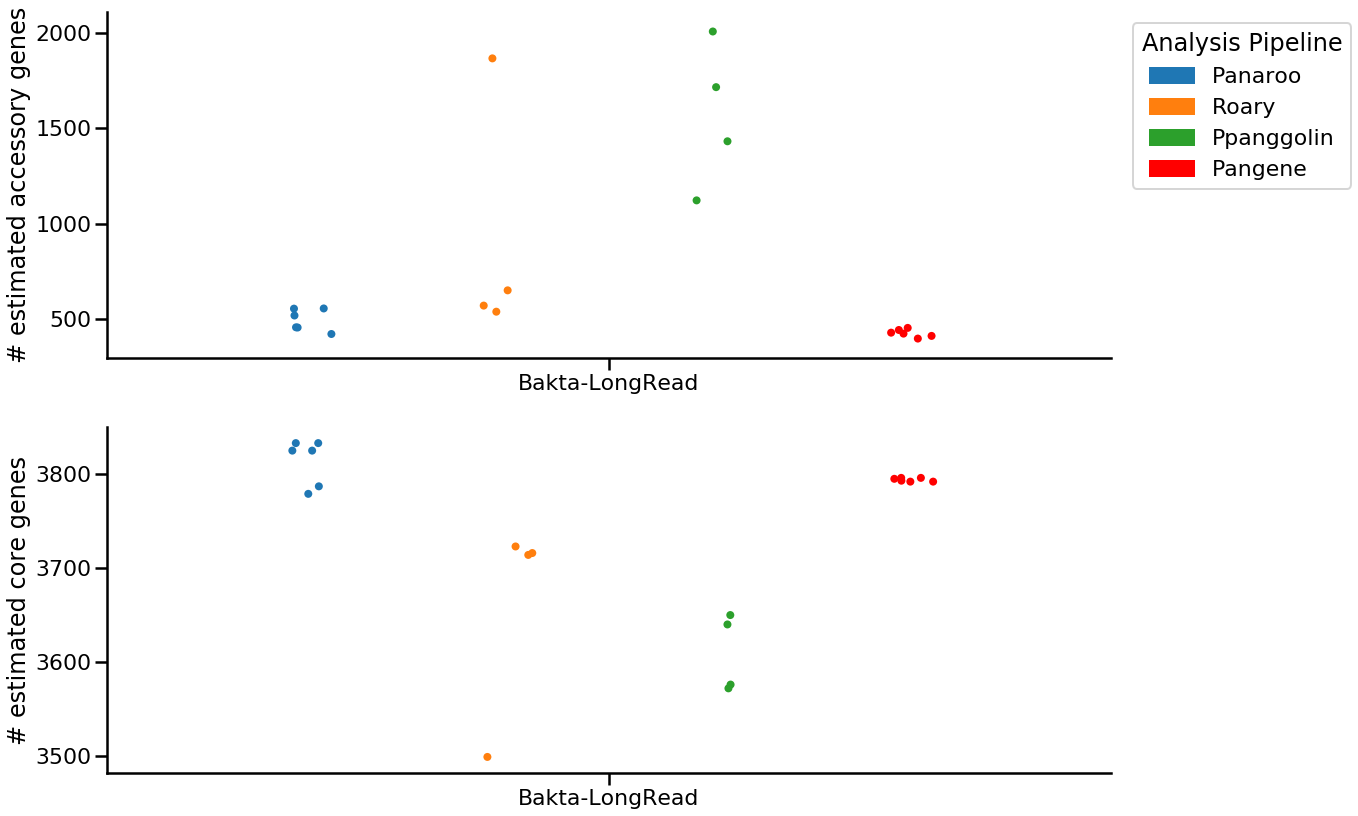

In [363]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (18, 14), sharey = False)


sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Acc_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Acc_DF, fliersize=0,
#             hue_order = hue_Order_Tools,
#             #order = Order_AnnoAndType,
#             ax= axs[0], boxprops=dict(alpha=0.4, linewidth=0),  )

sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Core_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Core_DF, fliersize=0,
#             hue_order = hue_Order_Tools, #order = Order_AnnoAndType,
#             ax= axs[1], boxprops=dict(alpha=0.4, linewidth=0),  )

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

sns.despine()

plt.show()